In [ ]:
import pandas as pd
import numpy as np

import networkx as nx

from itertools import chain, groupby
from tqdm import tqdm
import json
import matplotlib.pylab as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.rcParams['figure.figsize'] = [15, 15]

In [ ]:
edges1 = [['1', '2'], ['1', '3'], ['2', '3']]
edges2 = [['a', 'b'], ['b', 'c']]
edges3 = [['1', '2'], ['1', '3'], ['z', '1'], ['a', '1']]
edges4 = [['a', 'b'], ['b', 'c'], ['a', 'c'], ['c', 'z']]

edges5 = [['a', 'z'], ['6', '7'], ['a', '6'], ['a', '7']]
edges6 = [['w', 'y'], ['t', 'u'], ['w', 't']]

In [ ]:
nodes = ['1', '2', '3', 'a', 'b', 'c', 'z', '6', '7', 'w', 'y', 't', 'u']
nodes

['1', '2', '3', 'a', 'b', 'c', 'z', '6', '7', 'w', 'y', 't', 'u']

In [ ]:
g1 = nx.Graph()
g1.add_edges_from(edges1)
g1.add_nodes_from(['1', '2', '3'])

g2 = nx.Graph()
g2.add_edges_from(edges2)
g2.add_nodes_from(['a', 'b', 'c'])

g3 = nx.Graph()
g3.add_edges_from(edges3)
g3.add_nodes_from(['1', '2', '3', 'z', 'a'])

g4 = nx.Graph()
g4.add_edges_from(edges4)
g4.add_nodes_from(['a', 'b', 'c', 'z'])


g5 = nx.Graph()
g5.add_edges_from(edges5)
g5.add_nodes_from(['a', '6', '7', 'z'])


g6 = nx.Graph()
g6.add_edges_from(edges6)
g6.add_nodes_from(['w', 'y', 't', 'u'])

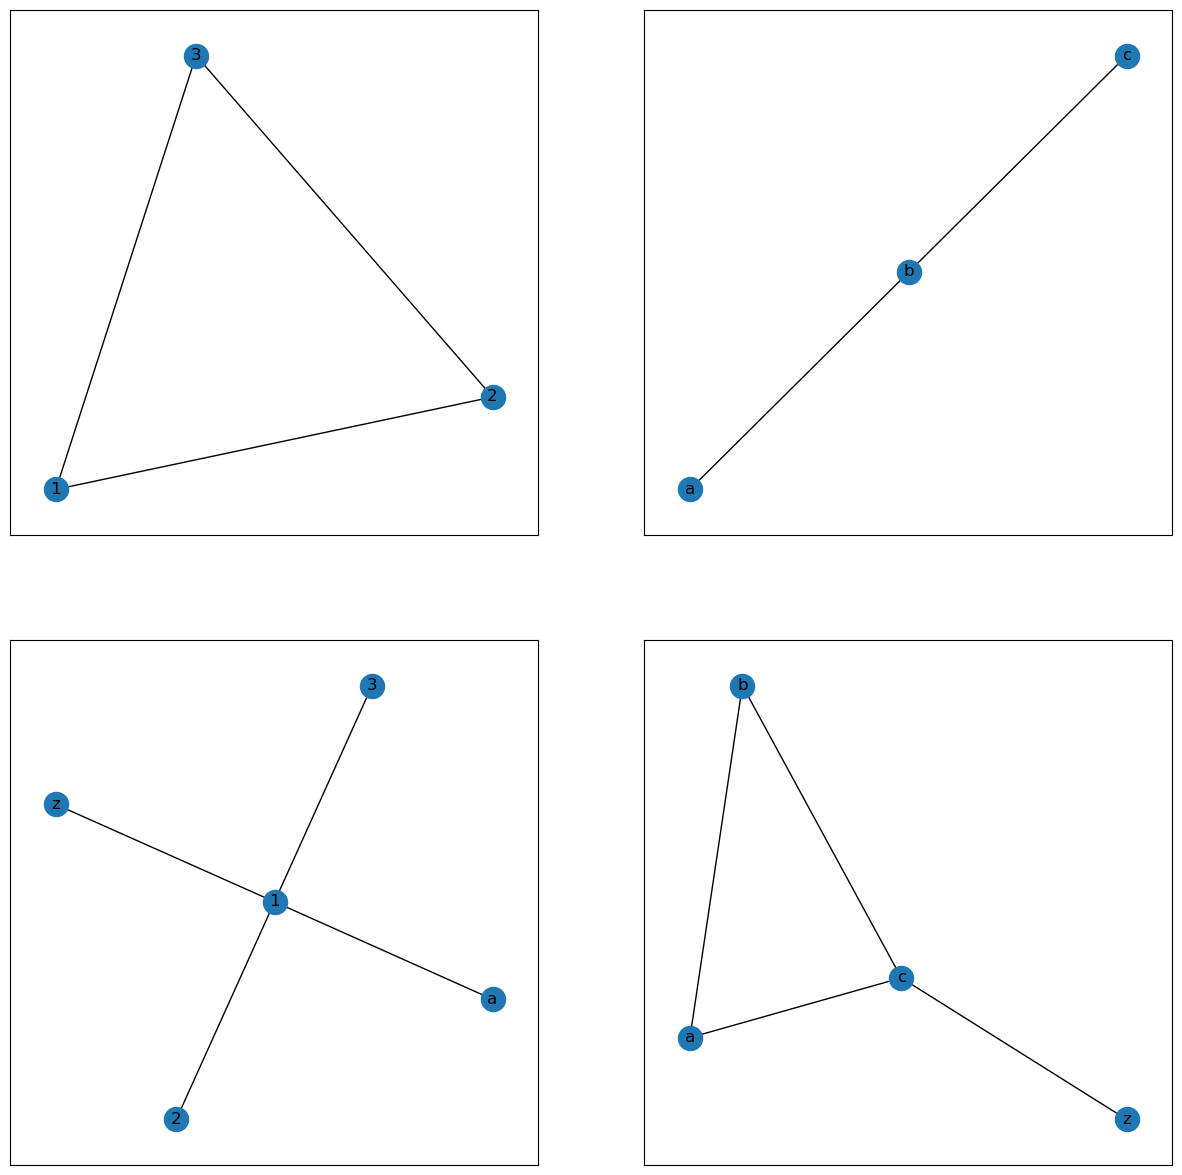

In [ ]:
fig, axs = plt.subplots(2,2)
plt.subplot(221)
nx.draw_networkx(g1)
plt.subplot(222)
nx.draw_networkx(g2)
plt.subplot(223)
nx.draw_networkx(g3)
plt.subplot(224)
nx.draw_networkx(g4)

In [ ]:
def get_graph(edges, nodes):
    g = nx.Graph()
    #g.add_weighted_edges_from(edges)
    g.add_edges_from(edges)
    g.add_nodes_from(nodes)
    return g

def matrix_prod_trace(A,B):
    n = len(A)
    diag_sum = 0
    for i in range(n):
        diag_sum += np.matmul(A[i,:],B[:,i])
    return diag_sum

def hash_p_stable(projection, r):
    bin_counts = {}
    for i in range(1):
        b = np.random.uniform(0,r)
        bin_hash = int(np.floor((projection + b ) / r ))
        bin_counts[bin_hash] = bin_counts.get(bin_hash, 0) + 1

    max_value = max(bin_counts, key=bin_counts.get)
    return max_value

def get_erdos_renyi_graph(n,p):
    done = True
    while done:
        g = nx.erdos_renyi_graph(n,p)
        if g.number_of_edges() > 0:
            return g

In [ ]:
edges = [edges1, edges2, edges3, edges4, edges5, edges6]

In [ ]:
num_graph = 6
graphs = []
y = []
for i in range(num_graph):
    graphs.append(get_graph(edges[i], nodes))

In [ ]:
%%time

num_proj = 2
B = 10

projections = []
bucket_ids = [''] * num_graph
for k in tqdm(range(num_proj)):
    erg = get_erdos_renyi_graph(len(nodes),0.8)
    A_er = nx.adjacency_matrix(erg)

    for i in range(num_graph):
        A = nx.adjacency_matrix(graphs[i])
        proj = matrix_prod_trace(A.toarray(),A_er.toarray())
        projections.append(proj)

    min_proj = min(projections)
    max_proj = max(projections)
    r = (max_proj - min_proj)/B
    for i in range(num_graph):
        hash_bin = hash_p_stable(projections[i], r)
        bucket_ids[i] += str(hash_bin)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 319.26it/s]

CPU times: user 9.04 ms, sys: 491 µs, total: 9.53 ms
Wall time: 8.77 ms


In [ ]:
bucket_ids

['1010', '55', '1515', '1010', '1010', '55']

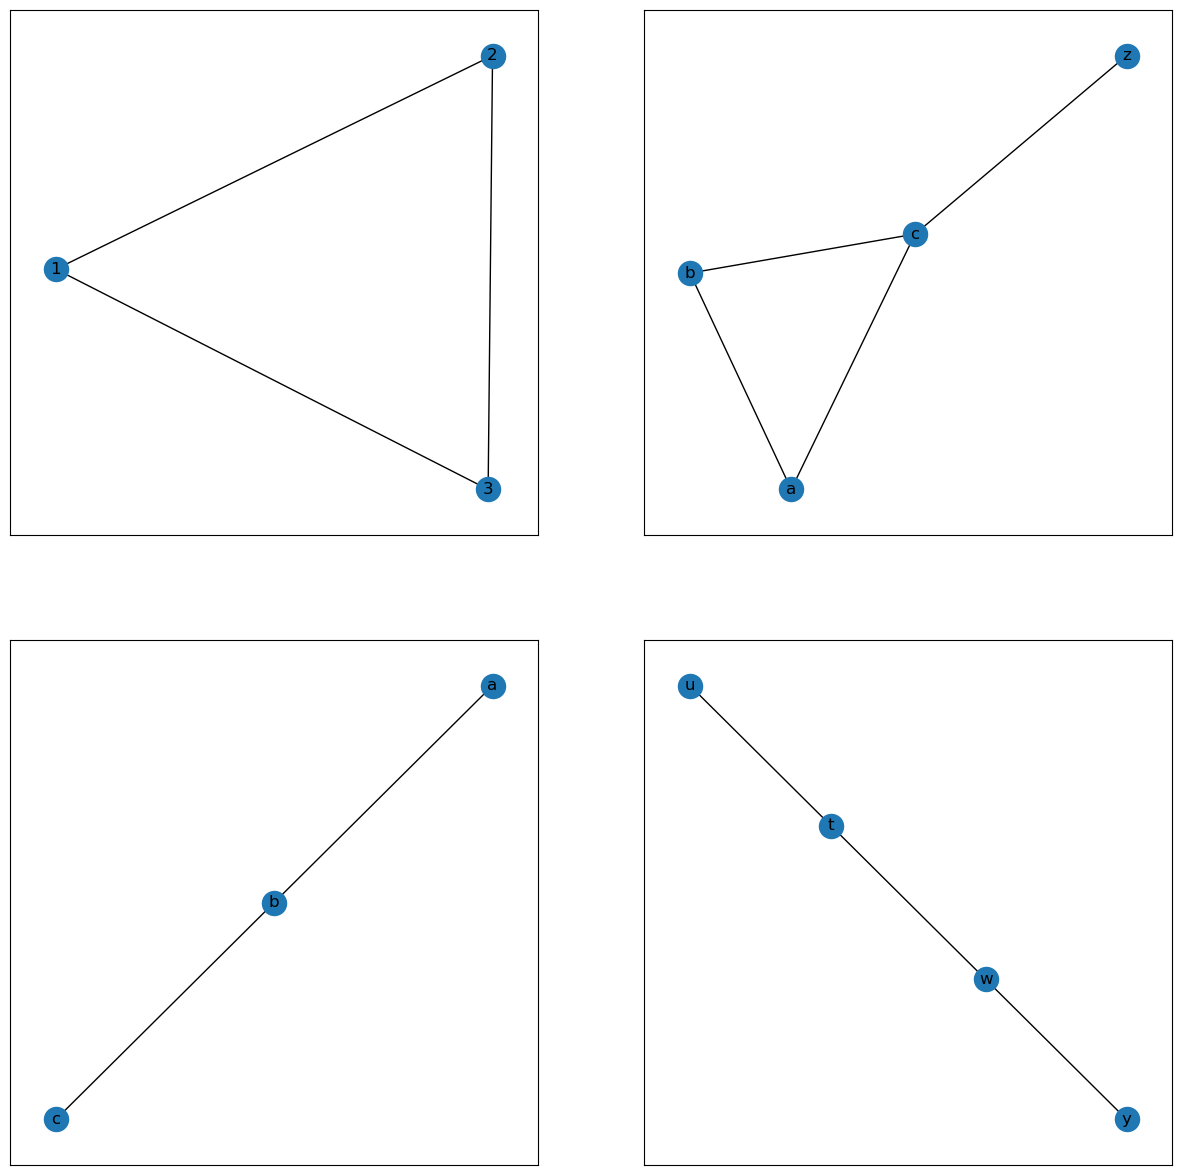

In [ ]:
fig, axs = plt.subplots(2,2)
plt.subplot(221)
nx.draw_networkx(g1)
plt.subplot(222)
nx.draw_networkx(g4)
plt.subplot(223)
nx.draw_networkx(g2)
plt.subplot(224)
nx.draw_networkx(g6)

# Ignoring nodes

In [ ]:
max_nodes = 5
nodes = list(range(max_nodes))

In [ ]:
def get_graph(edges, nodes):
    g = nx.Graph()
    g.add_edges_from(edges)
    g.add_nodes_from(nodes)
    return g

def get_adjacency(g, N):
    A = nx.adjacency_matrix(g).toarray()
    M = A.shape[0]
    A = np.pad(A, [(0, N-M), (0, N-M)], mode='constant')
    return A

In [ ]:
num_graph = 6
graphs = []
y = []
for i in range(num_graph):
    graphs.append(get_graph(edges[i], nodes))

In [ ]:
get_adjacency(graphs[3], max_nodes)


array([[0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
%%time

num_proj = 2
B = 10

projections = []
bucket_ids = [''] * num_graph
for k in tqdm(range(num_proj)):
    erg = get_erdos_renyi_graph(max_nodes,0.8)
    A_er = nx.adjacency_matrix(erg)

    for i in range(num_graph):
        A = get_adjacency(graphs[i], max_nodes)
        proj = matrix_prod_trace(A,A_er.toarray())
        projections.append(proj)

    min_proj = min(projections)
    max_proj = max(projections)
    r = (max_proj - min_proj)/B
    for i in range(num_graph):
        hash_bin = hash_p_stable(projections[i], r)
        bucket_ids[i] += str(hash_bin)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 424.31it/s]

CPU times: user 4.43 ms, sys: 4.11 ms, total: 8.54 ms
Wall time: 7.55 ms


In [ ]:
bucket_ids

['1510', '107', '2014', '2013', '2013', '1510']

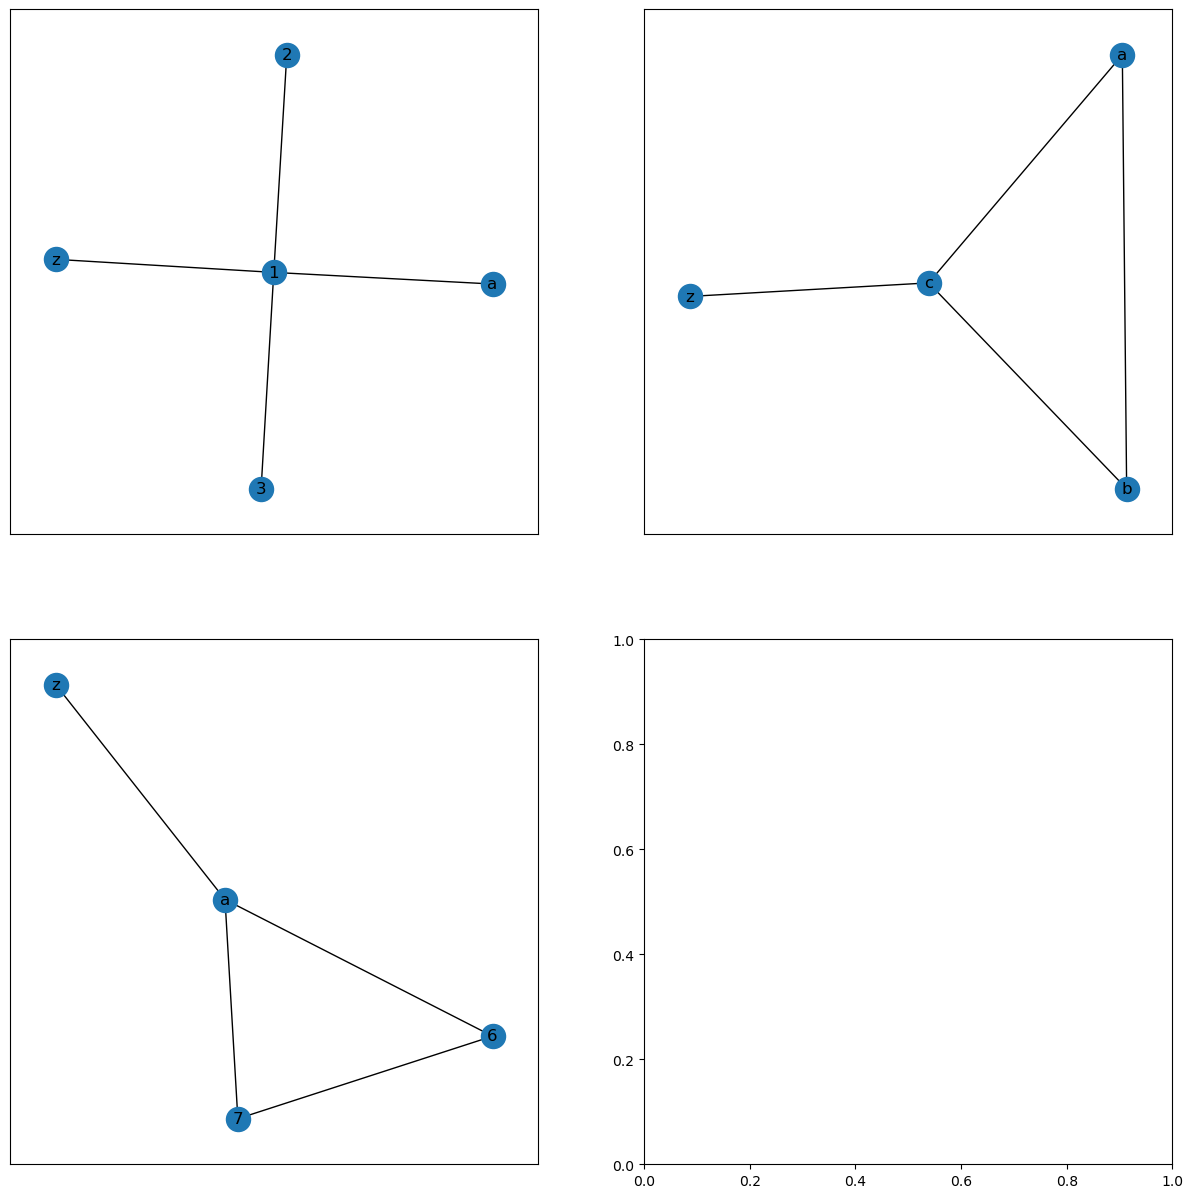

In [ ]:
fig, axs = plt.subplots(2,2)
plt.subplot(221)
nx.draw_networkx(g3)
plt.subplot(222)
nx.draw_networkx(g4)
plt.subplot(223)
nx.draw_networkx(g5)


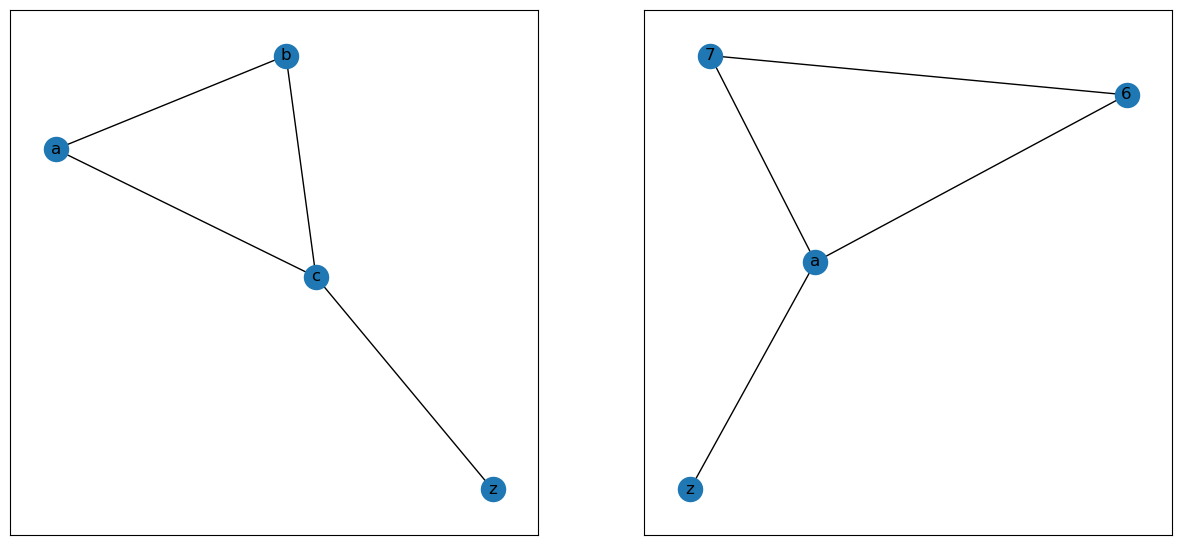

In [ ]:
fig, axs = plt.subplots(1,2)
plt.subplot(221)
nx.draw_networkx(graphs[3])
plt.subplot(222)
nx.draw_networkx(graphs[4])

# Jensen and Shannon divergence

In [ ]:
from networkx import normalized_laplacian_matrix

from numpy.linalg import eig
from scipy.linalg import logm

In [ ]:
def von_newmann_entropy(g):
    L = nx.laplacian_matrix(g)

    e, _ = eig(L.todense()/ (2*g.number_of_edges()))
    e = e[e>0]

    return -sum(e*np.log2(e))

# def aggregate(g1,g2):
#     A1 = nx.adjacency_matrix(g1)
#     A2 = nx.adjacency_matrix(g2)
#     return nx.from_numpy_array(np.ceil((A1.toarray()+A2.toarray())/2))

def get_adjacency(g, N):
    nodes_order = list(dict(sorted(g.degree, key=lambda x: x[1], reverse=True)).keys())
    #nodes_order = list(dict(g.degree).keys())

    A = nx.adjacency_matrix(g, nodelist=nodes_order).toarray()
    M = A.shape[0]
    A = np.pad(A, [(0, N-M), (0, N-M)], mode='constant')
    return A


def aggregate(g1,g2):
    A1 = get_adjacency(g1, 5)
    A2 = get_adjacency(g2, 5)
    return nx.from_numpy_array(np.ceil((A1+A2)/2))

def js_divergence(g1,g2):
    return np.sqrt(von_newmann_entropy(aggregate(g1,g2)) - (von_newmann_entropy(g1) + von_newmann_entropy(g2)) / 2)

In [ ]:
js_divergence(graphs[0],graphs[0])

0.0

In [ ]:
get_adjacency(graphs[3], 5)

array([[0, 1, 1, 1, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
get_adjacency(graphs[4], 5)

array([[0, 1, 1, 1, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
js_divergence(graphs[4],graphs[5])

0.39958557846146364

In [ ]:
js_divergence(graphs[3],graphs[4])

2.1073424255447017e-08